<a href="https://colab.research.google.com/github/SouhailChatti/Fraud_Detection/blob/master/m%C3%A9moire_d%C3%A9tection_de_fraude_Vf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction :**

Notre objectif dans ce projet est de construire des modèles pour prédire si une transaction par carte de crédit est frauduleuse. Nous tenterons une approche d'apprentissage supervisé. Nous créerons également des visualisations pour nous aider à comprendre la structure des données et à mettre au jour tout modèle intéressant.

***Importer des bibliothèques de base :***

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

import sklearn.utils
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split #Splitting the dataset
from sklearn.preprocessing import RobustScaler #Scaling the features
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc

from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from sklearn.decomposition import PCA

import keras
from keras.models import Sequential
from keras.layers import Dense,Input,  Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard

from imblearn.over_sampling import ADASYN #Adaptive Synthetic Oversampling
from collections import Counter
from scipy import stats

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')


# Librairie Google Colab
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Monte votre Google Drive sur le serveur.
drive.mount("/content/MyDrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/MyDrive/


# **Read Data** 

In [3]:
creditcard_data = pd.read_csv('/content/MyDrive/My Drive/creditcard.csv')
print(creditcard_data.shape)
creditcard_data.head(5)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* Notre dataset est un ensemble de données sur les transactions par carte de crédit effectuées sur une période de 2 jours en Septembre 2013 par les détenteurs de cartes européens
* Chaque transaction comporte 30 caractéristiques, toutes numériques.
* Les caractéristiques V1, V2, ..., V28 sont le résultat d'une transformation ACP (pour protéger la confidentialités, les informations de base sur ces caractéristiques ne sont pas disponibles).
* La caractéristique Temps contient le temps écoulé depuis la première transaction
* La caractéristique Montant contient le montant de la transaction. 
* La variable de réponse, Classe, est égale à 1 dans le cas d'une fraude, et à 0 dans les autres cas.

# ***Exploratory Data Analysis (EDA)***

In [6]:
creditcard_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
creditcard_data.isnull().any().any()
#Nous n'avons pas des variables pour lesquelles il manque des données 

False

In [ ]:
# On va voir la répartition de notre labels(classe), càd la fréquence des transactions frauduleuses et des transactions non frauduleuses
class_names = {0:'Not Fraud', 1:'Fraud'}
print(creditcard_data.Class.value_counts().rename(index = class_names))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


In [ ]:
# Les classes sont fortement déséquilibrées, nous devons résoudre ce problème plus tard.
print('No Frauds', round(creditcard_data['Class'].value_counts()[0]/len(creditcard_data) * 100,2), '% of the dataset')
print('Frauds', round(creditcard_data['Class'].value_counts()[1]/len(creditcard_data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Seulement 0,17 % (492 sur 284 807) des transactions sont frauduleuses ==> on a désequilibre sur les données.**

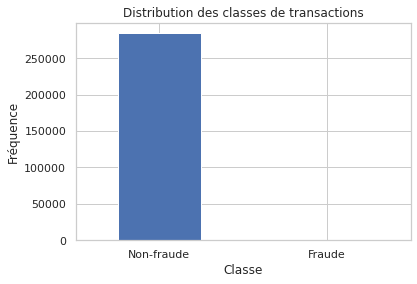

In [5]:
# Vérifions maintenant la répartition des classes
LABELS = ["Non-fraude", "Fraude"]

count_classes = pd.value_counts(creditcard_data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Distribution des classes de transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Classe")
plt.ylabel("Fréquence");

In [ ]:
fraud=creditcard_data[creditcard_data['Class']==1]
not_fraud=creditcard_data[creditcard_data['Class']==0]

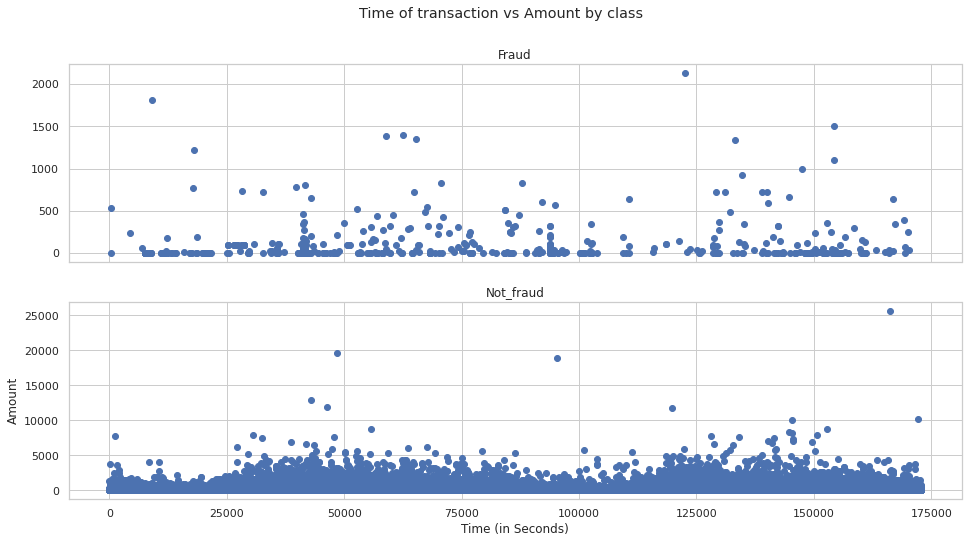

In [ ]:
#on va découvrir si les transactions frauduleuses sont plus fréquentes pendant certaines périodes ou pas 
rcParams['figure.figsize'] = 16, 8
f,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(not_fraud.Time, not_fraud.Amount)
ax2.set_title('Not_fraud')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

<Figure size 1152x576 with 0 Axes>

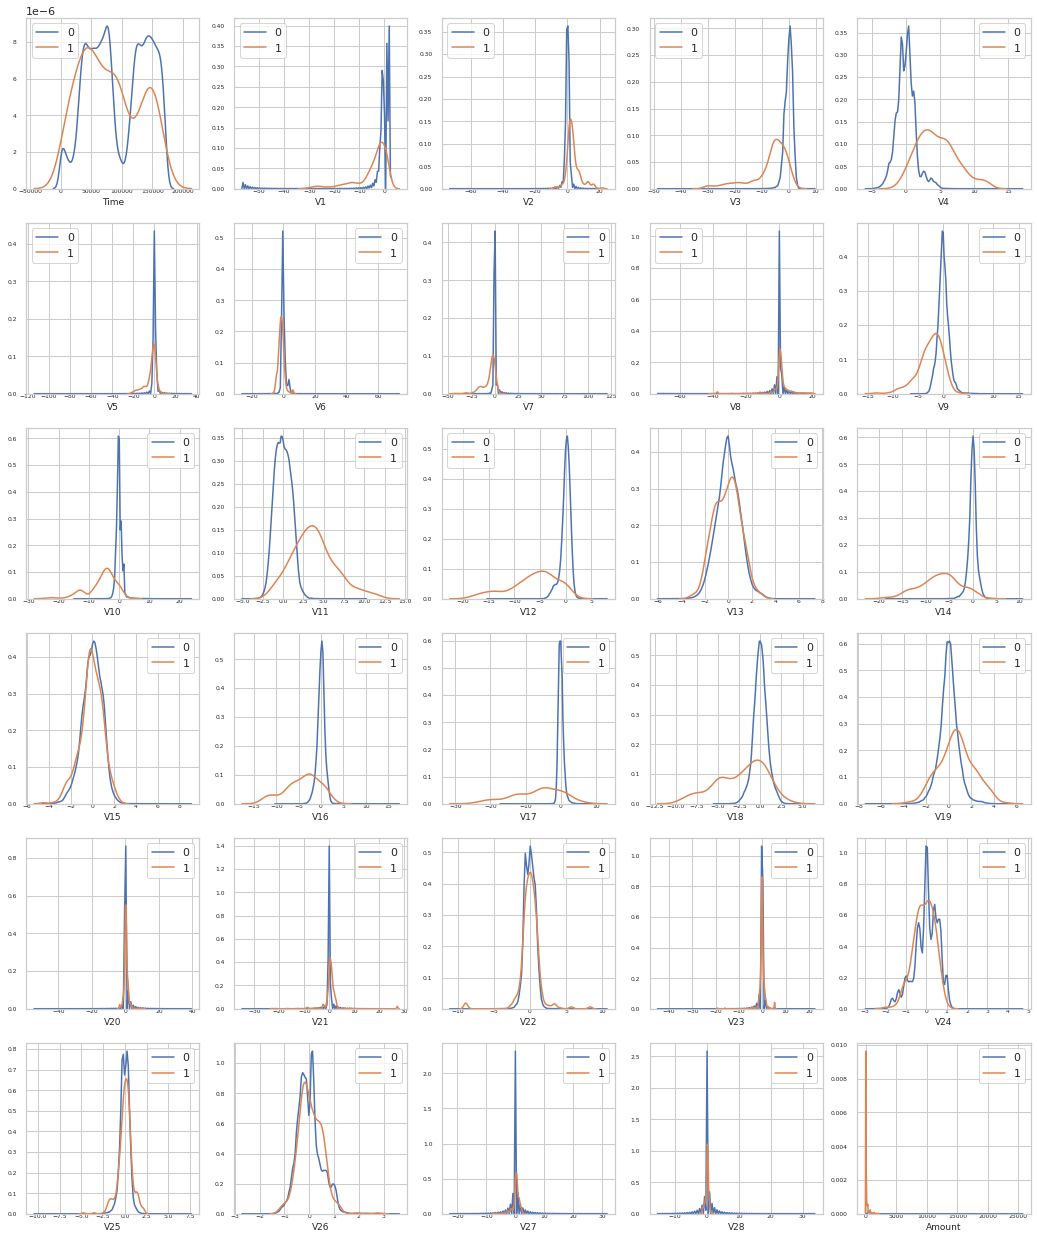

In [ ]:
#Features distribution

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(6,5,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(6,5,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()
    
t0 = creditcard_data.loc[creditcard_data['Class'] == 0]
t1 = creditcard_data.loc[creditcard_data['Class'] == 1]
features = creditcard_data.columns.values[:-1]
plot_feature_distribution(t0, t1, '0', '1', features)

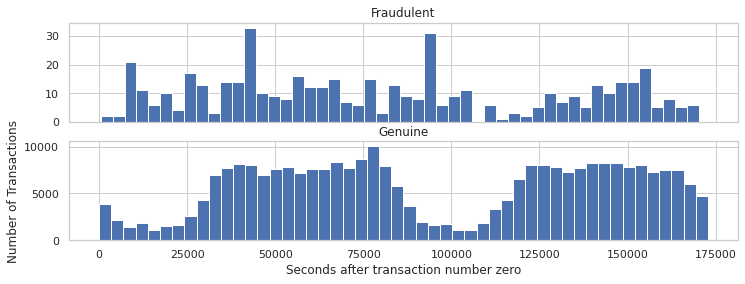

In [ ]:
#Histrogram for feature Time
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(creditcard_data["Time"][creditcard_data["Class"] == 1], bins = 50)
ax1.set_title('Fraudulent')

ax2.hist(creditcard_data["Time"][creditcard_data["Class"] == 0], bins = 50)
ax2.set_title('Genuine')

plt.xlabel('Seconds after transaction number zero')
plt.ylabel('Number of Transactions')
plt.show()

==> Les transactions se font de manière cyclique. Mais la fonction de temps (Time) ne fournit aucune information utile car l'heure à laquelle la première transaction a été initiée n'est pas donnée. Ainsi, nous allons laisser tomber cette fonctionnalité (feature) --> on va le dropper 

In [4]:
#dropping Time because it does not give any valuable information
creditcard_data = creditcard_data.drop("Time", axis = 1)
creditcard_data.shape

(284807, 30)

In [5]:
#Descriptive statistics for Fraudulent Transactions
print("Fraudulent Transactions")
creditcard_data['Amount'][creditcard_data['Class']==1]. describe()

Fraudulent Transactions


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [6]:
#Descriptive statistics for Genuine Transactions
print("Genuine Transactions")
creditcard_data['Amount'][creditcard_data['Class']==0]. describe()

Genuine Transactions


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

==> Le montant ne permet pas de déterminer grand-chose, car la plupart des transactions se situent autour de 100 dans les deux cas..

In [7]:
#Variance
creditcard_data.var()

V1            3.836489
V2            2.726820
V3            2.299029
V4            2.004684
V5            1.905081
V6            1.774946
V7            1.530401
V8            1.426479
V9            1.206992
V10           1.185594
V11           1.041855
V12           0.998403
V13           0.990571
V14           0.918906
V15           0.837803
V16           0.767819
V17           0.721373
V18           0.702539
V19           0.662662
V20           0.594325
V21           0.539526
V22           0.526643
V23           0.389951
V24           0.366808
V25           0.271731
V26           0.232543
V27           0.162919
V28           0.108955
Amount    62560.069046
Class         0.001725
dtype: float64

==> Le montant doit être échelonné (to be scaled). Comme si une caractéristique avait une variance d'un ordre de grandeur supérieur au reste des caractéristiques, elle pourrait alors dominer et rendre l'estimateur incapable de tirer des leçons des autres caractéristiques comme prévu.




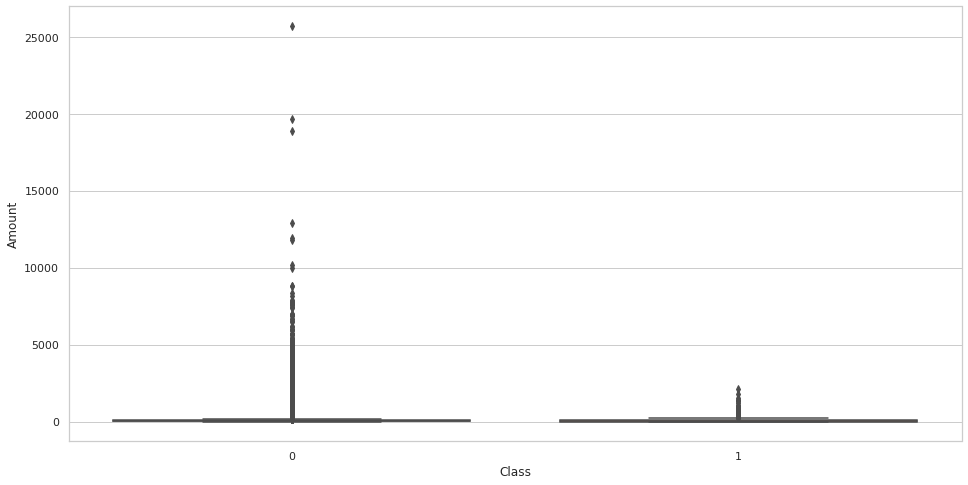

In [ ]:
#Boxplot for the Amount feature, in order to visualiza the outliers.
sns.boxplot(x=creditcard_data['Class'], y=creditcard_data['Amount'])

==> Les cas non frauduleux sont très biaisés. Les valeurs aberrantes (les outliers) peuvent être visualisées et il est donc préférable d'utiliser un échelle robuste pour mettre à l'échelle l'élément "Montant", car il est moins sujet aux valeurs aberrantes.

Text(0.5, 1.0, 'Imbalanced Correlation Matrix')

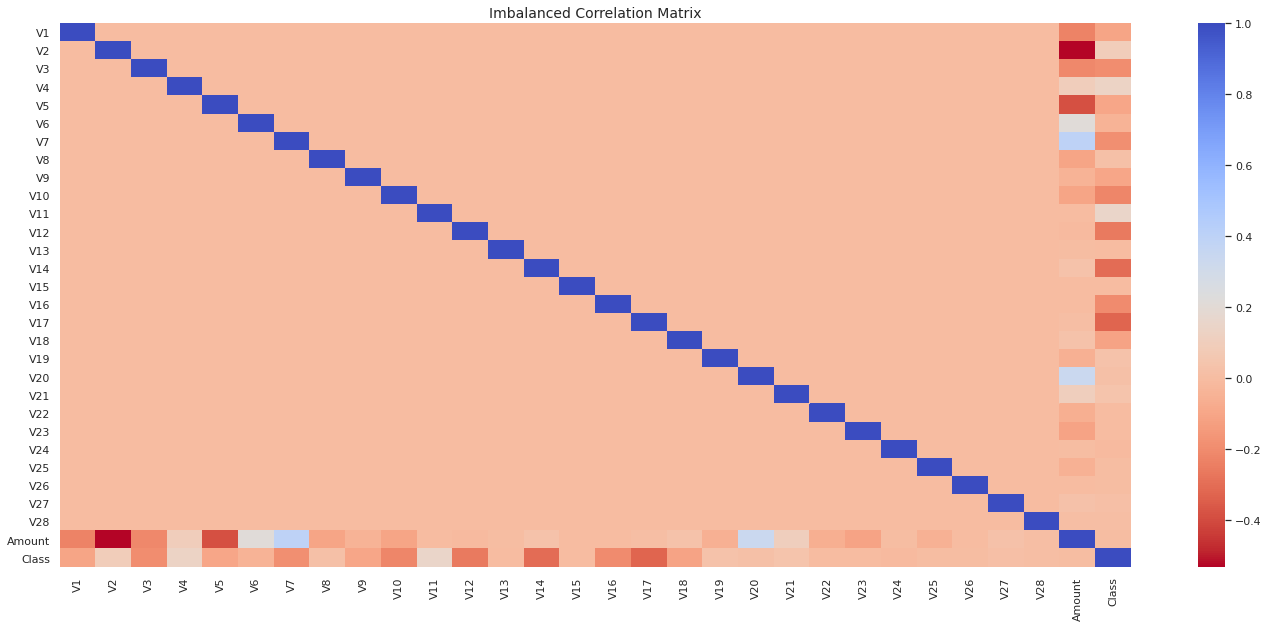

In [ ]:
#checking correlation between features and the likelihood of the transaction to be fraud on the unbalanced dataset
f, ax1 = plt.subplots(figsize=(24,10))

corr = creditcard_data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)

==> Comme nous l'avons vu, les corrélations ne peuvent être correctement visualisées en raison du déséquilibre de l'ensemble des données. En effet, la matrice de corrélation est affectée par le fort déséquilibre entre les classes. Donc, équilibrons nos classes et visualisons à nouveau la matrice de corrélation.

# ***Data Pre-processing***

**Scaling Amount**

In [8]:
#Standardizing the Amount column (All other 'V' columns are already scaled as they've undergone PCA transformation).
Rob_scaler=RobustScaler() #Robust to outliers
creditcard_data['Std_Amount'] = Rob_scaler.fit_transform(creditcard_data['Amount'].values.reshape(-1, 1))
creditcard_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Std_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.670579


In [9]:
#drop Amount and move Std_Amount at index '0'
creditcard_data = creditcard_data.drop('Amount',axis=1)

Std_Amount = creditcard_data['Std_Amount']
creditcard_data.drop('Std_Amount', axis=1, inplace=True)
creditcard_data.insert(0, 'Std_Amount', Std_Amount)
creditcard_data.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


**Splitting Data**

In [10]:

#Splitting data before sampling
#Splitting data into train and test set in 80% and 20% respectively, using Stratified Shuffle Split

X = creditcard_data.drop('Class', axis=1)
Y = creditcard_data['Class']

sss1 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index1, test_index in sss1.split(X, Y):
    print("Train:", train_index1, "Test:", test_index)
    Xtrain, Xtest = X.iloc[train_index1], X.iloc[test_index]
    Ytrain, Ytest = Y.iloc[train_index1], Y.iloc[test_index]

#Splitting the train set further into train and validation set, which leaves train set 60% of the originial dataset and, test and validation sets 20% each respectively.
sss2 = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

for train_index2, val_index in sss2.split(Xtrain, Ytrain):
    print("Train:", train_index2, "Validation:", val_index)
    Xtrain_final, Xval = X.iloc[train_index2], X.iloc[val_index]
    Ytrain_final, Yval = Y.iloc[train_index2], Y.iloc[val_index]

Train: [265518 180305  42664 ...  29062  13766  17677] Test: [263020  11378 147283 ... 274532 269819  64170]
Train: [ 72227 114282  16818 ... 264471 191914 284017] Test: [202638  32978 128121 ... 244024 127667  48318]
Train: [ 20895 114622 167683 ... 244502 178972 218506] Test: [284352  82483  90981 ... 171224 168807 271602]
Train: [122248 181660 194400 ... 104631 277586  29432] Test: [225673  63348  68025 ... 279451  77554  76043]
Train: [241684 223467 136928 ...  86495 160550  49633] Test: [157557 204860  83760 ... 251478 178967 216850]
Train: [186996 144807  69756 ... 195673 152135 100500] Validation: [214502 127768  18878 ...  45194 143895 114668]
Train: [203609 160516 170008 ... 168236  40608 156569] Validation: [152253  33885 217198 ... 219379 125093 195120]
Train: [166473 135845 190847 ... 114436 217810 119523] Validation: [135986 136793 153361 ... 221564 222657 122137]
Train: [ 16294 187750  97608 ... 157188 191303 201639] Validation: [125168  42557 218854 ... 117014  95701  40

 Les Datasets créés aprés le splitting sont:

* Train Dataset: Xtrain_final, Ytrain_final
* Test Dataset: Xtest, Ytest
* Validation Dataset: Xval, Yval

In [11]:
# Check if the labels are distributed equally in all the datasets after splitting
train_unique_label, train_counts_label = np.unique(Ytrain_final, return_counts=True)
test_unique_label, test_counts_label = np.unique(Ytest, return_counts=True)
val_unique_label, val_counts_label = np.unique(Yval, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(Ytrain_final))
print(test_counts_label/ len(Ytest))
print(val_counts_label/ len(Yval))

Label Distributions: 

[0.99807471 0.00192529]
[0.99827955 0.00172045]
[0.99845511 0.00154489]


==> Comme on l'a vu plus haut, les labels sont réparties presque également dans les trois ensembles de données

In [12]:

#Dimensionality of the datasets retrieved after splitting
print(Xtrain_final.shape)
print(Ytrain_final.shape)
print(Xtest.shape)
print(Ytest.shape)
print(Xval.shape)
print(Yval.shape)

(170883, 29)
(170883,)
(56962, 29)
(56962,)
(56962, 29)
(56962,)


In [13]:
#Converting Xtrain_final sets in numpy arrays
X_arr= Xtrain_final.values
Y_arr= Ytrain_final.values

In [14]:
#Converting test and validation dataframes in numpy arrays
Xval_arr=Xval.values
Yval_arr=Yval.values
Xtest_arr=Xtest.values
Ytest_arr=Ytest.values

# ***Model Building (Imbalanced Dataset)***

**Convolutional Neural Network (CNNs)**


In [162]:
#Training d'un perceptron multicouche (a Multi-layer perceptron) avec 2 couches cachées  (hidden layer) sans utiliser de dropout
n_inputs = X_arr.shape[1]
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
#Model Creation
model = Sequential()
model.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

In [163]:
# instance de modéle
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 65)                1950      
_________________________________________________________________
dropout_24 (Dropout)         (None, 65)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 65)                4290      
_________________________________________________________________
dropout_25 (Dropout)         (None, 65)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 66        
Total params: 6,306
Trainable params: 6,306
Non-trainable params: 0
_________________________________________________________________


In [164]:
#Compile Model
model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [165]:
#Fit Model
history= model.fit(X_arr, Y_arr, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=2)
print(history.history.keys())


Train on 170883 samples, validate on 56962 samples
Epoch 1/40
 - 1s - loss: 0.1095 - accuracy: 0.9719 - val_loss: 0.0081 - val_accuracy: 0.9992
Epoch 2/40
 - 1s - loss: 0.0181 - accuracy: 0.9985 - val_loss: 0.0060 - val_accuracy: 0.9994
Epoch 3/40
 - 1s - loss: 0.0126 - accuracy: 0.9988 - val_loss: 0.0042 - val_accuracy: 0.9995
Epoch 4/40
 - 1s - loss: 0.0109 - accuracy: 0.9989 - val_loss: 0.0034 - val_accuracy: 0.9995
Epoch 5/40
 - 1s - loss: 0.0096 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 6/40
 - 1s - loss: 0.0086 - accuracy: 0.9989 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 7/40
 - 1s - loss: 0.0067 - accuracy: 0.9990 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 8/40
 - 1s - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 9/40
 - 1s - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 10/40
 - 1s - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 11/40
 - 1s 

In [166]:
score = model.evaluate(Xtest_arr, Ytest_arr)

56962/56962 [==============================] - 1s 19us/step


In [167]:
print(score)

[0.004252888014295588, 0.9992275834083557]


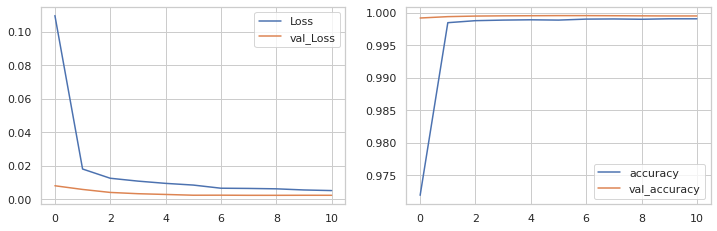

In [168]:
#Train Learning Curve : courbe d'apprentissage calculée à partir de traning dataset qui donne une idée 
#de la qualité d'apprentissage du modèle

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [169]:
#function for confusion matrix
def conf_matrix(predicted_values):
    Predictions_CM = confusion_matrix(Ytest_arr, predicted_values, labels = [0, 1])
    class_feat=creditcard_data['Class'].copy()
    class_feat= class_feat.unique()
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(Predictions_CM, annot=True, fmt='d', xticklabels=class_feat, yticklabels=class_feat)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

56962/56962 [==============================] - 1s 19us/step
Accuracy model (Dropout): 0.9992275834083557
Recall_score: 0.7346938775510204
Precision_score: 0.8
F-score: 0.7659574468085106


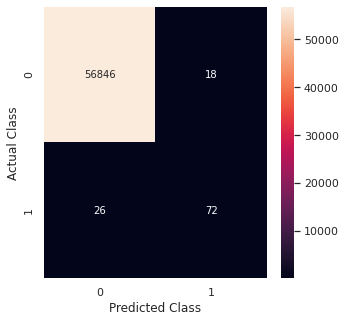

--------------------------------------------------
Réseau de neurones:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.73      0.77        98

    accuracy                           1.00     56962
   macro avg       0.90      0.87      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [170]:
Y_pred_cls = model.predict_classes(Xtest_arr, batch_size=200, verbose=0)
print('Accuracy model (Dropout): '+ str(model.evaluate(Xtest_arr,Ytest_arr)[1]))
print('Recall_score: ' + str(recall_score(Ytest_arr,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(Ytest_arr, Y_pred_cls)))
print('F-score: ' + str(f1_score(Ytest_arr,Y_pred_cls)))
conf_matrix(Y_pred_cls)

print('-'*50)

print('Réseau de neurones:')
print(classification_report(Ytest_arr, Y_pred_cls))

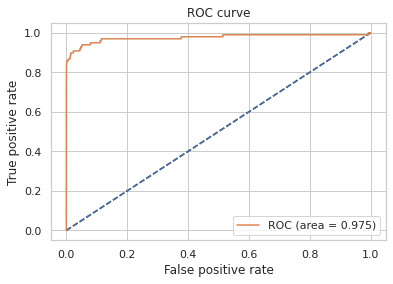

In [172]:
#Plotting ROC curve
Y_pred_prob = model.predict_proba(Xtest_arr).ravel()

fpr_model, tpr_model, thresholds_model = roc_curve(Ytest_arr, Y_pred_prob, pos_label=1)
auc_model = roc_auc_score(Ytest_arr, Y_pred_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
#plot the roc curve for the model
plt.plot(fpr_model, tpr_model, label='ROC (area = {:.3f})'.format(auc_model))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

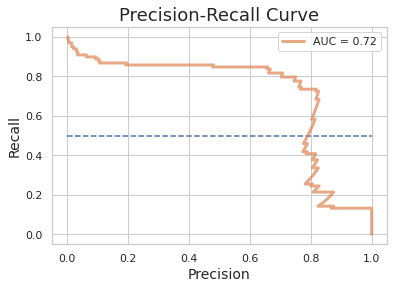

In [173]:
#Calculating Precision and Recall for various thresholds
precision, recall, thresholds_pr = precision_recall_curve(Ytest_arr, Y_pred_prob)

#Auc for PR curve
AUC_PRcurve= auc(recall, precision)

plt.figure(1)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
#plot PR curve
plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve), lw = 3, alpha = 0.7)
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()

# ***Model Building (Oversampling the minority class)***

***Data Pre-processing & EDA***

In [28]:
#Using ADASYN for Oversampling
ada = ADASYN(sampling_strategy='minority', random_state=42)

#Oversampling is applied only on the training set
X_adasampled, Y_adasampled = ada.fit_sample(Xtrain_final, Ytrain_final)
print('Resampled dataset shape %s' % Counter(Y_adasampled))
print('Shape of X_adasampled: {}'.format(X_adasampled.shape))
print('Shape of Y_adasampled: {}'.format(Y_adasampled.shape))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Resampled dataset shape Counter({1: 170555, 0: 170554})
Shape of X_adasampled: (341109, 29)
Shape of Y_adasampled: (341109,)


In [29]:
#check the disribution of both the labels
train_label, train_count = np.unique(Y_adasampled, return_counts=True)
print('Label Distributions: \n')
print(train_count/ len(Y_adasampled))

Label Distributions: 

[0.49999853 0.50000147]


In [30]:
print(type(X_adasampled))
print(type(Y_adasampled))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


==> X_adasampled et Y_adasampled sont les train set équilibrés obtenus après avoir utilisé le suréchantillonnage. Ce sont des ndarrays. Afin de visualiser une matrice de corrélation, elles sont converties en une DataFrame et jointes pour former une seule DataFrame dans la série de blocs ci-dessous.

In [31]:
Xsm_train_df = pd.DataFrame(X_adasampled)
Xsm_train_df.columns = Xtrain.columns
Ysm_train_df = pd.DataFrame(Y_adasampled)
Ysm_train_df = Ysm_train_df.rename(columns={0: 'Class'})
print(Xsm_train_df.head())
print(Ysm_train_df.head())

   Std_Amount        V1        V2        V3        V4        V5        V6  \
0   -0.286173 -0.313555  0.586734  3.039981  2.848687 -0.158865  0.838171   
1    0.237546  1.883183 -0.640580  0.094691  0.386752 -0.859323  0.238667   
2    1.170265 -5.593796 -3.140554 -0.055757  1.539374  1.321195  1.449076   
3   -0.267729 -0.851124  0.819195  2.014788 -0.634556 -0.166583  0.779931   
4    1.369384 -1.339343  0.842304  2.210153  3.009876 -0.501056  1.506612   

         V7        V8        V9       V10       V11       V12       V13  \
0 -0.305911  0.136755  1.081775  0.190786  1.566877 -1.306409  2.261768   
1 -1.172713  0.238254  2.560352 -0.207867  1.593968 -2.091775  0.657869   
2  0.494910 -0.187489  1.098618  1.431163  0.976218 -0.105310 -0.533431   
3 -0.248282  0.440142  1.000038 -0.481232 -1.688925 -0.769379 -0.451602   
4  0.044767  0.574622 -0.545759  0.505751 -1.288283 -0.062102  0.341931   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.423097

In [32]:
#Merging the Xsm_train_df and Ysm_train_df based on the index values to get a single dataframe in order to visualize a correlation matrix
new_df= pd.merge(Xsm_train_df, Ysm_train_df, how='inner', left_index=True, right_index=True)
new_df.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.286173,-0.313555,0.586734,3.039981,2.848687,-0.158865,0.838171,-0.305911,0.136755,1.081775,0.190786,1.566877,-1.306409,2.261768,0.423097,-2.814955,-0.167124,0.553623,0.508003,0.211776,0.064667,-0.064730,0.538368,0.017643,0.514390,-0.970922,-0.131954,0.072962,-0.014056,0
1,0.237546,1.883183,-0.640580,0.094691,0.386752,-0.859323,0.238667,-1.172713,0.238254,2.560352,-0.207867,1.593968,-2.091775,0.657869,1.521056,-0.504496,0.901775,-0.099007,0.959121,-0.228614,-0.191241,-0.063316,0.025427,0.346800,0.700140,-0.686270,0.387537,-0.060475,-0.044121,0
2,1.170265,-5.593796,-3.140554,-0.055757,1.539374,1.321195,1.449076,0.494910,-0.187489,1.098618,1.431163,0.976218,-0.105310,-0.533431,-0.428713,1.919602,-0.086262,-0.420286,-0.143536,0.313058,-3.165442,-0.732926,1.617461,1.182141,-1.534997,0.203254,-0.308358,-0.982457,-0.584698,0
3,-0.267729,-0.851124,0.819195,2.014788,-0.634556,-0.166583,0.779931,-0.248282,0.440142,1.000038,-0.481232,-1.688925,-0.769379,-0.451602,-0.335154,1.871080,0.431517,-0.786848,1.318962,0.608179,0.309633,0.133497,0.615617,-0.475375,0.010686,0.582486,-0.302416,0.486000,0.209563,0
4,1.369384,-1.339343,0.842304,2.210153,3.009876,-0.501056,1.506612,0.044767,0.574622,-0.545759,0.505751,-1.288283,-0.062102,0.341931,-0.507927,0.204678,-0.490637,0.598714,-0.376962,1.033634,0.245178,-0.188658,-0.159114,-0.241138,-0.402550,0.057283,0.231537,0.067849,-0.249524,0


==> Ainsi, les DataFrames Xsm_train_df and Ysm_train_df sont fusionnés pour former un nouveau DataFrame "new_df", avec 30 attributs au total comprenant "Std_Amount", "V1-V28" de Xsm_train_df et "Class" de Ysm_train_df.

Text(0.5, 1.0, 'Balanced Correlation Matrix')

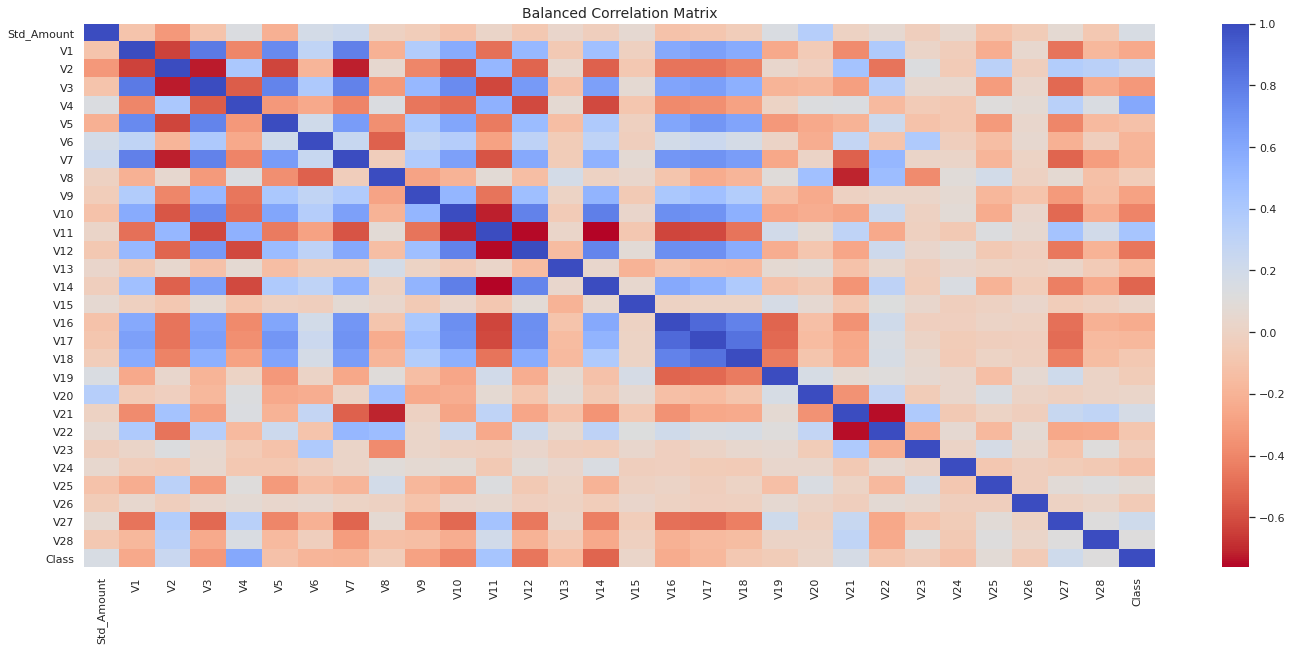

In [ ]:
#checking correlation between features on the balanced dataset
f, ax1 = plt.subplots(figsize=(24,10))

corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Balanced Correlation Matrix", fontsize=14)

==> Des corrélations négatives et positives peuvent être observées dans la matrice ci-dessus :

Les caractéristiques, V14, V12, V10 et V3 montrent une corrélation négative vers la "Classe", car plus ces valeurs sont basses, plus il est probable que la transaction soit une fraude.

Les caractéristiques V4, V11, V2 et V19 présentent une corrélation positive. Plus ces valeurs sont élevées, plus il est probable que la transaction soit une fraude.


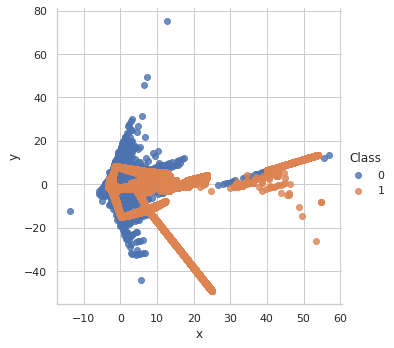

In [ ]:
#visualizing balanced train dataset
pca= PCA(n_components=2)

X_df= pd.DataFrame(X_adasampled)
Y_df= pd.DataFrame(Y_adasampled)
Y_df=Y_df.rename(columns={0: 'Class'})
train_2d= pd.DataFrame(pca.fit_transform(X_df.iloc[:,0:29]))
train_2d= pd.concat([train_2d, Y_df], axis=1)
train_2d.columns= ['x', 'y', 'Class']
sns.lmplot(x='x', y='y', data=train_2d, fit_reg=False, hue='Class')

==> Le graphique ci-dessus donne une représentation visuelle du dataset équilibré. Comme on l'a vu, les données ne sont pas séparables de manière linéaire. Ainsi, un Perceptron multicouche est formé sur ces données, afin de prédire si elles sont "frauduleuses" ou "authentiques". Pour l'entraînement du perceptron multicouche, de nombreux paramètres doivent être réglés, c'est pourquoi une recherche par grille est utilisée à cette fin. La recherche de grille est effectuée sur le sous-ensemble des données, car elle prend beaucoup de temps. Les blocs suivants créent un sous-ensemble de l'ensemble de données en utilisant un sous-échantillonnage aléatoire utilisé uniquement à cette fin.


In [33]:
#An undersampled dataset is created to tune the parameters using Grid-Search
Ytrain_df = pd.DataFrame(Ytrain_final)
Ytrain_df = Ytrain_df.rename(columns={0: 'Class'})
Train_set= pd.merge(Xtrain_final, Ytrain_df, how='inner', left_index=True, right_index=True)
Train_set.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
14162,-0.286173,-0.313555,0.586734,3.039981,2.848687,-0.158865,0.838171,-0.305911,0.136755,1.081775,0.190786,1.566877,-1.306409,2.261768,0.423097,-2.814955,-0.167124,0.553623,0.508003,0.211776,0.064667,-0.064730,0.538368,0.017643,0.514390,-0.970922,-0.131954,0.072962,-0.014056,0
152802,0.237546,1.883183,-0.640580,0.094691,0.386752,-0.859323,0.238667,-1.172713,0.238254,2.560352,-0.207867,1.593968,-2.091775,0.657869,1.521056,-0.504496,0.901775,-0.099007,0.959121,-0.228614,-0.191241,-0.063316,0.025427,0.346800,0.700140,-0.686270,0.387537,-0.060475,-0.044121,0
227171,1.170265,-5.593796,-3.140554,-0.055757,1.539374,1.321195,1.449076,0.494910,-0.187489,1.098618,1.431163,0.976218,-0.105310,-0.533431,-0.428713,1.919602,-0.086262,-0.420286,-0.143536,0.313058,-3.165442,-0.732926,1.617461,1.182141,-1.534997,0.203254,-0.308358,-0.982457,-0.584698,0
217316,-0.267729,-0.851124,0.819195,2.014788,-0.634556,-0.166583,0.779931,-0.248282,0.440142,1.000038,-0.481232,-1.688925,-0.769379,-0.451602,-0.335154,1.871080,0.431517,-0.786848,1.318962,0.608179,0.309633,0.133497,0.615617,-0.475375,0.010686,0.582486,-0.302416,0.486000,0.209563,0
80544,1.369384,-1.339343,0.842304,2.210153,3.009876,-0.501056,1.506612,0.044767,0.574622,-0.545759,0.505751,-1.288283,-0.062102,0.341931,-0.507927,0.204678,-0.490637,0.598714,-0.376962,1.033634,0.245178,-0.188658,-0.159114,-0.241138,-0.402550,0.057283,0.231537,0.067849,-0.249524,0


In [ ]:
Train_set.shape

(170883, 30)

In [ ]:
#Length of Frauds
length_frauds=len(Train_set[Train_set.Class==1])
length_frauds

329

In [ ]:

#Taking only Frauds in a dataframe
fraud_df= Train_set.loc[Train_set['Class'] == 1]
fraud_df.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
143188,-0.279466,-3.003459,2.096150,-0.487030,3.069453,-1.774329,0.251804,-4.328776,-2.425478,-0.985222,-3.995211,1.880602,-2.325179,0.636459,-5.417499,-0.262909,-3.818086,-3.700707,-1.991412,0.779951,0.692537,0.163967,1.245648,-0.269241,0.537102,-0.220757,-0.059555,0.460710,-0.033551,1
86155,1.110878,-2.756007,0.683821,-1.390169,1.501887,-1.165614,-0.131207,-1.478741,-0.246922,-0.100523,-2.301110,1.914454,-3.830998,0.719489,-6.353020,1.438716,-3.297239,-4.862971,-2.002354,1.545233,-0.106945,0.320474,0.611027,0.174864,-0.502151,-0.174713,1.179242,-1.166315,0.821215,1
9487,-0.293440,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.241368,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1
163586,0.600852,0.949241,1.333519,-4.855402,1.835006,-1.053245,-2.562826,-2.286986,0.260906,-0.895366,-4.542612,2.453710,-4.925199,-1.200412,-6.424372,1.014897,-3.129421,-5.147039,-1.815437,0.520497,0.424608,0.306598,-0.854627,0.101177,-0.281497,0.024444,-0.107944,0.625289,0.315677,1
223578,-0.183050,-5.256434,0.364541,-5.412085,2.400031,0.697301,-1.998755,-5.835532,-0.887739,-2.828287,-4.614508,2.710697,-3.158156,1.083609,-3.415152,-1.053870,-3.751031,-9.261641,-2.955165,0.606571,-0.403685,-0.648259,0.511285,-1.110045,0.178987,0.220235,-0.699809,0.580487,-0.173630,1


In [ ]:
#Taking only Non-frauds
non_fraud_df= Train_set.loc[Train_set['Class'] == 0]
#Randomly select the same number of records as the Frauds
non_frauds=non_fraud_df.sample(n=length_frauds)
non_frauds.shape

(329, 30)

In [ ]:
#Appending both Frauds and Non-Frauds
undersampled_df= fraud_df.append(non_frauds)
#Randomly shuffling all the instances
undersampled_df = sklearn.utils.shuffle(undersampled_df)
undersampled_df.head()

,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
43428,4.781527,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1
172329,2.333543,1.780412,-1.252955,-1.354515,-0.594442,-0.820917,-0.464597,-0.766289,-0.035377,-0.217474,0.160462,1.146919,-0.069111,0.325695,-1.916001,-0.294680,1.911383,1.059439,0.075600,0.486541,0.402095,0.380317,0.785079,-0.094091,-0.480627,-0.208828,-0.100589,-0.003199,0.004652,0
127848,-0.286453,-0.663822,0.677133,1.308075,-0.456809,0.589190,-0.558711,0.568400,0.020533,-0.715819,-0.380058,1.668527,1.156186,0.515217,0.236842,-0.239629,0.115885,-0.564495,-0.374776,-0.924972,-0.194736,0.185975,0.509156,-0.196374,0.273945,-0.092822,0.205064,-0.097780,0.001555,0
70428,-0.209739,-2.792204,-1.407437,1.983544,0.080520,-0.729561,0.138763,-1.127400,0.356450,0.463323,0.759965,-1.317679,-0.431231,-0.572586,-0.972574,-0.175260,-1.138215,-0.097763,1.334411,-2.114012,-1.632651,-0.317683,0.492006,0.537405,0.054465,-0.029748,-0.394510,-0.878792,0.220571,0
18773,-0.297911,0.269614,3.549755,-5.810353,5.809370,1.538808,-2.269219,-0.824203,0.351070,-3.759059,-4.592390,5.479392,-5.657858,-2.648076,-10.384890,-0.225946,-0.701883,0.409736,0.939604,-1.954300,0.310525,0.371121,-0.322290,-0.549856,-0.520629,1.378210,0.564714,0.553255,0.402400,1


In [ ]:
#Separating labels from the other features
X_undersample = undersampled_df.drop('Class', axis=1)
Y_undersample = undersampled_df['Class']
print(X_undersample.shape)
print(Y_undersample.shape)
X_undersample.head()

(658, 29)
(658,)


,Std_Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
43428,4.781527,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804
172329,2.333543,1.780412,-1.252955,-1.354515,-0.594442,-0.820917,-0.464597,-0.766289,-0.035377,-0.217474,0.160462,1.146919,-0.069111,0.325695,-1.916001,-0.294680,1.911383,1.059439,0.075600,0.486541,0.402095,0.380317,0.785079,-0.094091,-0.480627,-0.208828,-0.100589,-0.003199,0.004652
127848,-0.286453,-0.663822,0.677133,1.308075,-0.456809,0.589190,-0.558711,0.568400,0.020533,-0.715819,-0.380058,1.668527,1.156186,0.515217,0.236842,-0.239629,0.115885,-0.564495,-0.374776,-0.924972,-0.194736,0.185975,0.509156,-0.196374,0.273945,-0.092822,0.205064,-0.097780,0.001555
70428,-0.209739,-2.792204,-1.407437,1.983544,0.080520,-0.729561,0.138763,-1.127400,0.356450,0.463323,0.759965,-1.317679,-0.431231,-0.572586,-0.972574,-0.175260,-1.138215,-0.097763,1.334411,-2.114012,-1.632651,-0.317683,0.492006,0.537405,0.054465,-0.029748,-0.394510,-0.878792,0.220571
18773,-0.297911,0.269614,3.549755,-5.810353,5.809370,1.538808,-2.269219,-0.824203,0.351070,-3.759059,-4.592390,5.479392,-5.657858,-2.648076,-10.384890,-0.225946,-0.701883,0.409736,0.939604,-1.954300,0.310525,0.371121,-0.322290,-0.549856,-0.520629,1.378210,0.564714,0.553255,0.402400


In [ ]:
#Converting undersampled train sets in numpy arrays
X_us_arr= X_undersample.values
Y_us_arr= Y_undersample.values

Le code du bloc suivant est utilisé pour le réglage hyperparamétrique des différents paramètres nécessaires à l'entraînement d'un perceptron multicouche. Il est commenté car il prend beaucoup de temps à exécuter. Il est exécuté sur l'ensemble de données sous-échantillonné créé ci-dessus. De plus, le plus grand défi est la reproductibilité. Même après l'utilisation de la semence, les résultats produits varient un peu. Mais après plusieurs exécutions, les paramètres renvoyés sont : neuron_1=65, dropout_rate=0.5, init_mode='he_normal', learn_rate=0.001

In [ ]:
#Grid Search for hyperparameter tuning
#def create_model(neuron_1=29, dropout_rate=0.0, init_mode='uniform', learn_rate=0.01):
     #n_inputs = X_undersample.shape[1]
     #model = Sequential()
     #model.add(Dense(neuron_1, input_shape=(n_inputs, ), kernel_initializer=init_mode, activation= 'relu'))
     #model.add(Dropout(dropout_rate))
     #model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))
     #model.compile(Adam(lr=learn_rate), loss='binary_crossentropy')
     #return model

#Keras models can be used with scikit learn by wrapping them with KerasClassifier
#model_tuning = KerasClassifier(build_fn=create_model,epochs=30, batch_size=700, verbose=1)

#neuron_1= [29, 30, 35, 40, 45, 50,55,60,65,70]
#learn_rate= [0.001, 0.01, 0.1, 0.2, 0.3]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#param_grid = dict(neuron_1=neuron_1, dropout_rate=dropout_rate, init_mode=init_mode, learn_rate=learn_rate)
#grid = GridSearchCV(estimator=model_tuning, param_grid=param_grid, scoring=make_scorer(f1_score), cv=5, n_jobs=-1)
#grid_result = grid.fit(X_us_arr, Y_us_arr)

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#mean_score = grid_result.cv_results_['mean_test_score']
#std_score = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(mean_score, std_score, params):
      #print("%f (%f) with: %r" % (mean, stdev, param))
 
 

In [42]:
#Training a Multi-layer perceptron with 1 hidden layer on Oversampled dataset without using dropout and, using the parameters tuned above.
n_inputs = X_adasampled.shape[1]
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
#Model Creation
Model1 = Sequential()
Model1.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model1.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

#Compile Model
Model1.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
Model1.summary()

#Fit Model
history1= Model1.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=30, callbacks=[es], shuffle=True, verbose=2)
print(history1.history.keys())

#Best: 0.943857 using {'dropout_rate': 0.5, 'init_mode': 'he_normal', 'learn_rate': 0.001, 'neuron_1': 65}

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 65)                1950      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 66        
Total params: 2,016
Trainable params: 2,016
Non-trainable params: 0
_________________________________________________________________
Train on 341109 samples, validate on 56962 samples
Epoch 1/30
 - 1s - loss: 0.0755 - accuracy: 0.9783 - val_loss: 0.0259 - val_accuracy: 0.9923
Epoch 2/30
 - 1s - loss: 0.0126 - accuracy: 0.9974 - val_loss: 0.0188 - val_accuracy: 0.9954
Epoch 3/30
 - 1s - loss: 0.0072 - accuracy: 0.9986 - val_loss: 0.0121 - val_accuracy: 0.9971
Epoch 4/30
 - 1s - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.0104 - val_accuracy: 0.9983
Epoch 5/30
 - 1s - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.0097 - val_accuracy: 0.998

In [43]:
score = Model1.evaluate(Xtest_arr, Ytest_arr)

56962/56962 [==============================] - 1s 17us/step


In [44]:
print(score)

[0.005047328914058386, 0.9992626905441284]


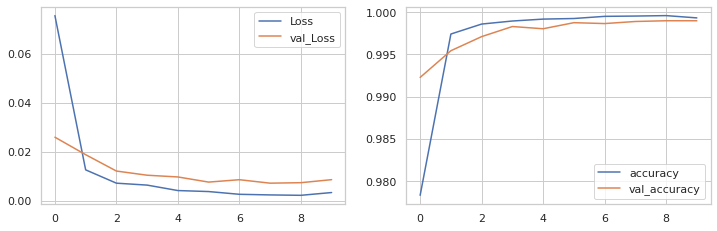

In [45]:
#Train Learning Curve : courbe d'apprentissage calculée à partir de traning dataset qui donne une idée 
#de la qualité d'apprentissage du modèle

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], label='Loss')
plt.plot(history1.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.legend()

==> La variation des performances du train et des données de validation montre qu'il a été sur-appris sur l'ensemble des données du train. Essayons donc d'ajouter le Dropout et de voir son effet sur la performance du modèle.

In [78]:
#Training a Multi-layer perceptron with 1 hidden layer on Oversampled dataset using the parameters tuned above and adding a Dropout.
n_inputs = X_adasampled.shape[1]
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
Model1_drop = Sequential()
Model1_drop.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model1_drop.add(Dropout(0.5))
Model1_drop.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Model1_drop.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
Model1_drop.summary()

history2= Model1_drop.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=2)
print(history2.history.keys())


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 65)                1950      
_________________________________________________________________
dropout_17 (Dropout)         (None, 65)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 66        
Total params: 2,016
Trainable params: 2,016
Non-trainable params: 0
_________________________________________________________________
Train on 341109 samples, validate on 56962 samples
Epoch 1/40
 - 1s - loss: 0.3350 - accuracy: 0.8592 - val_loss: 0.1415 - val_accuracy: 0.9529
Epoch 2/40
 - 1s - loss: 0.1341 - accuracy: 0.9562 - val_loss: 0.0800 - val_accuracy: 0.9725
Epoch 3/40
 - 1s - loss: 0.0901 - accuracy: 0.9749 - val_loss: 0.0594 - val_accuracy: 0.9792
Epoch 4/40
 - 1s - loss: 0.0677 - accuracy: 0.9830 

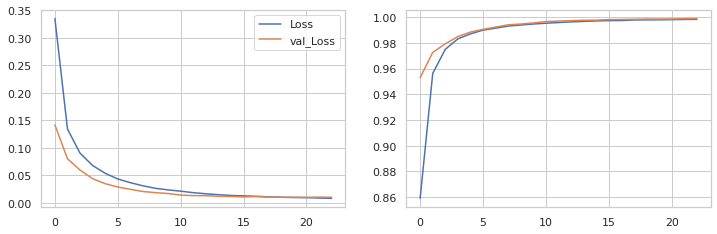

In [79]:
#Train Learning Curve : courbe d'apprentissage calculée à partir de traning dataset qui donne une idée 
#de la qualité d'apprentissage du modèle

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history2.history['loss'], label='Loss')
plt.plot(history2.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')

==> Comme observé, avec l'ajout de Dropout, le dataset de validation est plus performant. Et les performances du train et de l'ensemble de validation sont comparables.

56962/56962 [==============================] - 1s 17us/step
Accuracy Model1 (Dropout): 0.9983673095703125
Recall_score: 0.9591836734693877
Precision_score: 0.5136612021857924
F-score: 0.6690391459074733


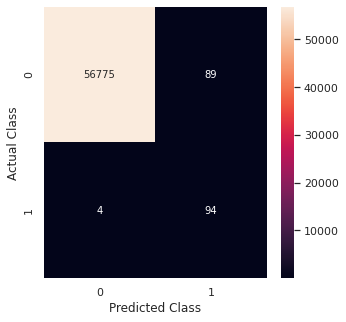

--------------------------------------------------
Réseau de neurones:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.96      0.67        98

    accuracy                           1.00     56962
   macro avg       0.76      0.98      0.83     56962
weighted avg       1.00      1.00      1.00     56962



In [80]:
Y_pred_cls = Model1_drop.predict_classes(Xtest_arr, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(Model1_drop.evaluate(Xtest_arr,Ytest_arr)[1]))
print('Recall_score: ' + str(recall_score(Ytest_arr,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(Ytest_arr, Y_pred_cls)))
print('F-score: ' + str(f1_score(Ytest_arr,Y_pred_cls)))
conf_matrix(Y_pred_cls)

print('-'*50)

print('Réseau de neurones:')
print(classification_report(Ytest_arr, Y_pred_cls))

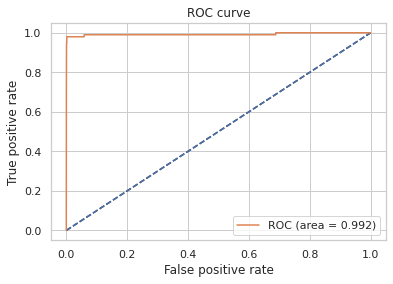

In [58]:
#Plotting ROC curve
Y_pred_prob = Model1_drop.predict_proba(Xtest_arr).ravel()

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(Ytest_arr, Y_pred_prob, pos_label=1)
auc_model1 = roc_auc_score(Ytest_arr, Y_pred_prob)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
#plot the roc curve for the model
plt.plot(fpr_model1, tpr_model1, label='ROC (area = {:.3f})'.format(auc_model1))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

==> Les courbes ROC ne sont généralement pas bien adaptées aux ensembles de données déséquilibrés, car elles utilisent TN. Ainsi, ils peuvent être trompeurs. En revanche, les TN ne sont pas pris en compte dans la courbe des PR (PR_Curve). Ils sont donc plus adaptés à une classification déséquilibrée.

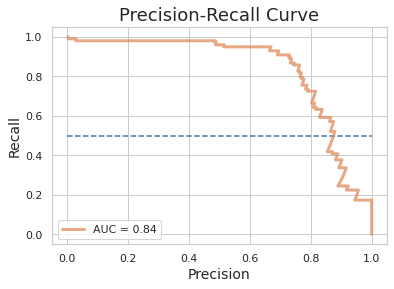

In [59]:
#Calculating Precision and Recall for various thresholds
precision, recall, thresholds_pr = precision_recall_curve(Ytest_arr, Y_pred_prob)

#Auc for PR curve
AUC_PRcurve= auc(recall, precision)

plt.figure(1)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
#plot PR curve
plt.plot(precision, recall, label = "AUC = {:0.2f}".format(AUC_PRcurve), lw = 3, alpha = 0.7)
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [ ]:
#Training Multi-layer Perceptron with single hidden layer for 60 iterations and, appending the F-score for each iteration.
f_scorelist1=[]

n_inputs = X_adasampled.shape[1]
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
for i in range(0,60):
    First_Model = Sequential()
    First_Model.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
    First_Model.add(Dropout(0.5))
    First_Model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

    First_Model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    First_Model.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=0)
    Y_first_pred = First_Model.predict_classes(Xtest_arr, batch_size=200, verbose=0)
    
    f_score= f1_score(Ytest_arr,Y_first_pred)
    f_scorelist1.append(f_score)

print(f_scorelist1)
print('FScore Mean: '+ str(np.mean(f_scorelist1)))
print('-'*88)

In [75]:
#Training Multi-layer perceptron with 2 hidden layers
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
Model2 = Sequential()
Model2.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
Model2.add(Dropout(0.5))
Model2.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

Model2.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
his_mod2= Model2.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=2)
print(his_mod2.history.keys())


Train on 341109 samples, validate on 56962 samples
Epoch 1/40
 - 2s - loss: 0.4151 - accuracy: 0.8387 - val_loss: 0.1245 - val_accuracy: 0.9578
Epoch 2/40
 - 2s - loss: 0.1353 - accuracy: 0.9555 - val_loss: 0.0586 - val_accuracy: 0.9803
Epoch 3/40
 - 2s - loss: 0.0714 - accuracy: 0.9811 - val_loss: 0.0301 - val_accuracy: 0.9909
Epoch 4/40
 - 2s - loss: 0.0446 - accuracy: 0.9893 - val_loss: 0.0214 - val_accuracy: 0.9943
Epoch 5/40
 - 2s - loss: 0.0322 - accuracy: 0.9927 - val_loss: 0.0171 - val_accuracy: 0.9961
Epoch 6/40
 - 2s - loss: 0.0254 - accuracy: 0.9944 - val_loss: 0.0136 - val_accuracy: 0.9971
Epoch 7/40
 - 2s - loss: 0.0205 - accuracy: 0.9957 - val_loss: 0.0125 - val_accuracy: 0.9976
Epoch 8/40
 - 2s - loss: 0.0179 - accuracy: 0.9963 - val_loss: 0.0117 - val_accuracy: 0.9981
Epoch 9/40
 - 2s - loss: 0.0153 - accuracy: 0.9970 - val_loss: 0.0113 - val_accuracy: 0.9985
Epoch 10/40
 - 2s - loss: 0.0132 - accuracy: 0.9973 - val_loss: 0.0112 - val_accuracy: 0.9985
Epoch 11/40
 - 2s 

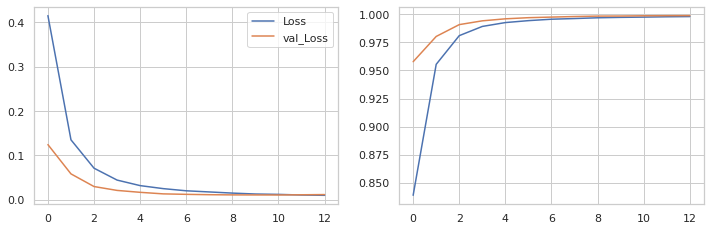

In [76]:
#Train Learning Curve : courbe d'apprentissage calculée à partir de traning dataset qui donne une idée 
#de la qualité d'apprentissage du modèle

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(his_mod2.history['loss'], label='Loss')
plt.plot(his_mod2.history['val_loss'], label='val_Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(his_mod2.history['accuracy'], label='accuracy')
plt.plot(his_mod2.history['val_accuracy'], label='val_accuracy')

56962/56962 [==============================] - 1s 19us/step
Accuracy MLP: 0.9986131191253662
56962/56962 [==============================] - 1s 19us/step
Loss value: 0.007450183983252451
Recall_score: 0.9489795918367347
Precision_score: 0.5568862275449101
F-score: 0.7018867924528301


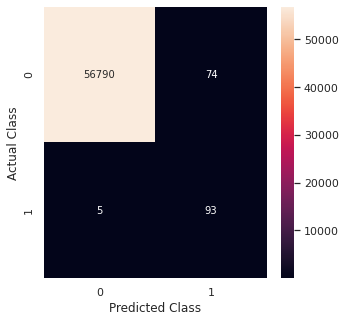

--------------------------------------------------
Réseau de neurones:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.56      0.95      0.70        98

    accuracy                           1.00     56962
   macro avg       0.78      0.97      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [77]:
print('Accuracy MLP: '+ str(Model2.evaluate(Xtest_arr,Ytest_arr)[1]))
print('Loss value: '+ str(Model2.evaluate(Xtest_arr,Ytest_arr)[0]))

Y_mod2_pred = Model2.predict_classes(Xtest_arr, batch_size=200, verbose=0)
print('Recall_score: ' + str(recall_score(Ytest_arr,Y_mod2_pred)))
print('Precision_score: ' + str(precision_score(Ytest_arr, Y_mod2_pred)))
print('F-score: ' + str(f1_score(Ytest_arr,Y_mod2_pred)))
conf_matrix(Y_mod2_pred)

print('-'*50)

print('Réseau de neurones:')
print(classification_report(Ytest_arr, Y_mod2_pred))

Tout d'abord, comparons les courbes ROC et PR avant d'itérer le modèle.

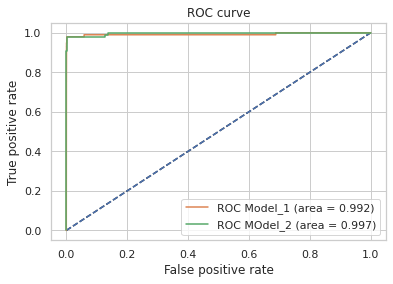

In [81]:
Y_pred_prob2 = Model2.predict_proba(Xtest_arr).ravel()

fpr_model2, tpr_model2, thresholds_model2 = roc_curve(Ytest_arr, Y_pred_prob2, pos_label=1)
auc_model2 = roc_auc_score(Ytest_arr, Y_pred_prob2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
#plot the roc curve for the model
plt.plot(fpr_model1, tpr_model1, label='ROC Model_1 (area = {:.3f})'.format(auc_model1))
plt.plot(fpr_model2, tpr_model2, label='ROC MOdel_2 (area = {:.3f})'.format(auc_model2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

==> Comme on l'a observé, la courbe ROC n'est d'aucune utilité. Elle ne fournit aucune information utile. Ainsi, considérons une courbe R-P

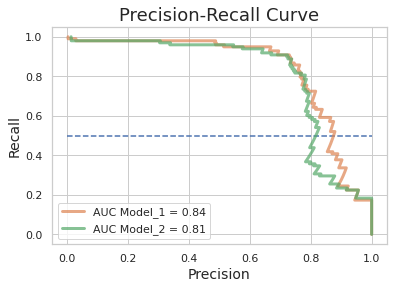

In [82]:
#Calculating Precision and Recall for various thresholds
precision_2, recall_2, thresholds_pr_2 = precision_recall_curve(Ytest_arr, Y_pred_prob2)

#Auc for PR curve
AUC_PRcurve_2= auc(recall_2, precision_2)

plt.figure(1)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
#plot PR curve
plt.plot(precision, recall, label = "AUC Model_1 = {:0.2f}".format(AUC_PRcurve), lw = 3, alpha = 0.7)
plt.plot(precision_2, recall_2, label = "AUC Model_2 = {:0.2f}".format(AUC_PRcurve_2), lw = 3, alpha = 0.7)
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(loc='best')
plt.show()

In [ ]:
#Iterating Model-2 with 2 hidden layer for 60 iterations.

f_scorelist2=[]

n_inputs = X_adasampled.shape[1]
es= keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='min', restore_best_weights= True)
for i in range(0,60):
    
    Second_Model = Sequential()
    Second_Model.add(Dense(65, input_shape=(n_inputs, ), kernel_initializer='he_normal', activation='relu'))
    Second_Model.add(Dropout(0.5))
    Second_Model.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
    Second_Model.add(Dropout(0.5))
    Second_Model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

    Second_Model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    Second_Model.fit(X_adasampled, Y_adasampled, validation_data=(Xval_arr, Yval_arr), batch_size=700, epochs=40, callbacks=[es], shuffle=True, verbose=0)
    Y_second_pred = Second_Model.predict_classes(Xtest_arr, batch_size=200, verbose=0)
    
    f_score= f1_score(Ytest_arr,Y_second_pred)
    f_scorelist2.append(f_score)

print(f_scorelist2)
print('FScore Mean: '+ str(np.mean(f_scorelist2)))
print('-'*88)

[0.6690140845070423, 0.6785714285714285, 0.6506849315068494, 0.6032786885245902, 0.6287625418060201, 0.632996632996633, 0.7116104868913858, 0.6460481099656358, 0.6714801444043321, 0.6323024054982818, 0.6503496503496504, 0.6840148698884759, 0.636986301369863, 0.6551724137931035, 0.6787003610108303, 0.6440677966101696, 0.6595744680851063, 0.627450980392157, 0.6287625418060201, 0.6739926739926739, 0.6886446886446886, 0.6270627062706271, 0.6375838926174496, 0.6308724832214765, 0.6440677966101696, 0.681159420289855, 0.6089743589743589, 0.6394557823129252, 0.6597222222222222, 0.6810035842293907, 0.6506849315068494, 0.6305084745762712, 0.6642599277978339, 0.673913043478261, 0.6480836236933798, 0.6959706959706958, 0.6480836236933798, 0.6911764705882353, 0.6787003610108303, 0.6416382252559727, 0.6785714285714285, 0.6859205776173285, 0.6595744680851063, 0.6323024054982818, 0.6245847176079734, 0.6863468634686347, 0.6506849315068494, 0.657243816254417, 0.6000000000000001, 0.6985294117647058, 0.593

#RESULTS ANALYSIS
Si l'hypothèse nulle est acceptée, cela signifie qu'il n'y a pas de différence entre les ensembles de données et que la modification du nombre de couches cachées n'affecte pas les performances du modèle.

Si l'hypothèse nulle est rejetée, cela signifie qu'il y a une différence significative entre les ensembles de données et que la modification du nombre de couches cachées affecte les performances du modèle.



In [ ]:

#Comparing the mean performance of the F-score for both the models
print('Model-1')
print('---------')
print('Average F-Score: '+ str(np.mean(f_scorelist1)))

print('-'*40)

print('Model-2')
print('---------')
print('Average F-Score: '+ str(np.mean(f_scorelist2)))

In [ ]:
#Comparing the Standard Deviation for F-scores generated after iterations
fscore_df1=pd.DataFrame(f_scorelist1)

print('Model-1')
print('------------------')
print('F_score SD: ' + str(fscore_df1.std()))

print('-'*40)

fscore_df2=pd.DataFrame(f_scorelist2)

print('Model-2')
print('------------------')
print('F_score SD: ' + str(fscore_df2.std()))

Model-1
------------------
F_score SD: 0    0.036826
dtype: float64
----------------------------------------
Model-2
------------------
F_score SD: 0    0.028013
dtype: float64


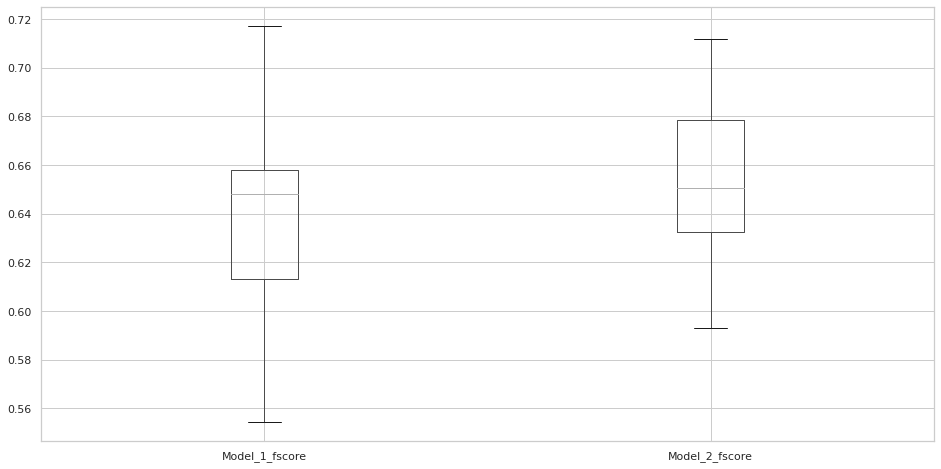

In [ ]:
#Visualize the results using a boxplot()

results_fscore= pd.concat([fscore_df1, fscore_df2], axis=1)
results_fscore.columns = ['Model_1_fscore', 'Model_2_fscore']

results_fscore.boxplot()

In [ ]:
#Tester l'hypothèse nulle qu'un échantillon provient d'une distribution normale
alpha = 0.05;

s, p = stats.normaltest(fscore_df1)
if p < alpha:
  print('Model-1 Data is not normal')
else:
  print('Model-1 Data is normal')

s, p = stats.normaltest(fscore_df2)
if p < alpha:
  print('Model-2 Data is not normal')
else:
  print('Model-2 Data is normal')

Model-1 Data is normal
Model-2 Data is normal


In [ ]:

#Wilcoxon Signed-Rank Test
#It tests the null hypothesis that two related paired samples come from the same distribution.
#It is a non-parametric version of the paired T-test.

s, p = stats.wilcoxon(fscore_df1[0], fscore_df2[0])

if p < 0.05:
  print('null hypothesis rejected, significant difference between the data-sets')
else:
  print('null hypothesis accepted, no significant difference between the data-sets')

null hypothesis rejected, significant difference between the data-sets


===> l'hypothèse nulle est rejetée, donc cela signifie qu'il y a une différence significative entre les ensembles de données et que la modification du nombre de couches cachées affecte les performances du modèle.

**On retient le deuxiéme modéle avec 2 couches cachée**

# ***Others model (LR, KNN, CART, SVM, XGB, RF)***

**Splitting the dataset into training and test data**

In [85]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(creditcard_data, test_size=0.2)

In [86]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

**Using SMOTE to remove data imbalance**

In [87]:
X_train = train.loc[:,:'V28']
y_train = train.loc[:,'Class']

In [88]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [89]:
train_res = np.concatenate((X_train_res, y_train_res.reshape((-1,1))), axis = 1)
np.random.shuffle(train_res)
train_res = pd.DataFrame(train_res, columns=train.columns)

Text(0.5, 0, 'Class - 0:Non-Fraudulent; 1:Fraudulent')

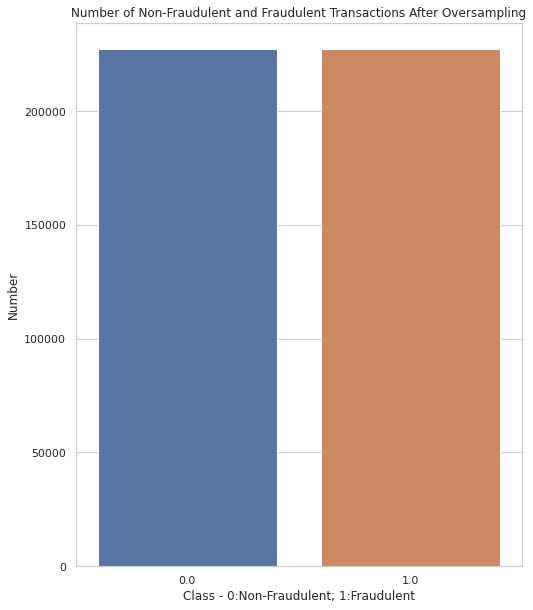

In [90]:
counts = train_res['Class'].value_counts()
plt.figure(figsize=(8,10))
sns.barplot(x=counts.index, y=counts)
plt.title('Number of Non-Fraudulent and Fraudulent Transactions After Oversampling')
plt.ylabel('Number')
plt.xlabel('Class - 0:Non-Fraudulent; 1:Fraudulent')

**Outlier Detection and Removal**

In [91]:
corr = train_res.corr()
corr = corr[['Class']]
print(corr)

               Class
Std_Amount  0.051210
V1         -0.424864
V2          0.506566
V3         -0.565158
V4          0.711726
V5         -0.389684
V6         -0.457939
V7         -0.471973
V8          0.131424
V9         -0.573447
V10        -0.631252
V11         0.697988
V12        -0.680338
V13        -0.062359
V14        -0.752270
V15        -0.047527
V16        -0.593385
V17        -0.564820
V18        -0.471015
V19         0.261405
V20         0.209923
V21         0.128585
V22         0.031859
V23        -0.030646
V24        -0.078639
V25         0.057563
V26         0.045623
V27         0.068626
V28         0.095038
Class       1.000000


In [92]:
# features with high negative correlations
corr[corr['Class'] < -0.5]

,Class
V3,-0.565158
V9,-0.573447
V10,-0.631252
V12,-0.680338
V14,-0.752270
V16,-0.593385
V17,-0.564820


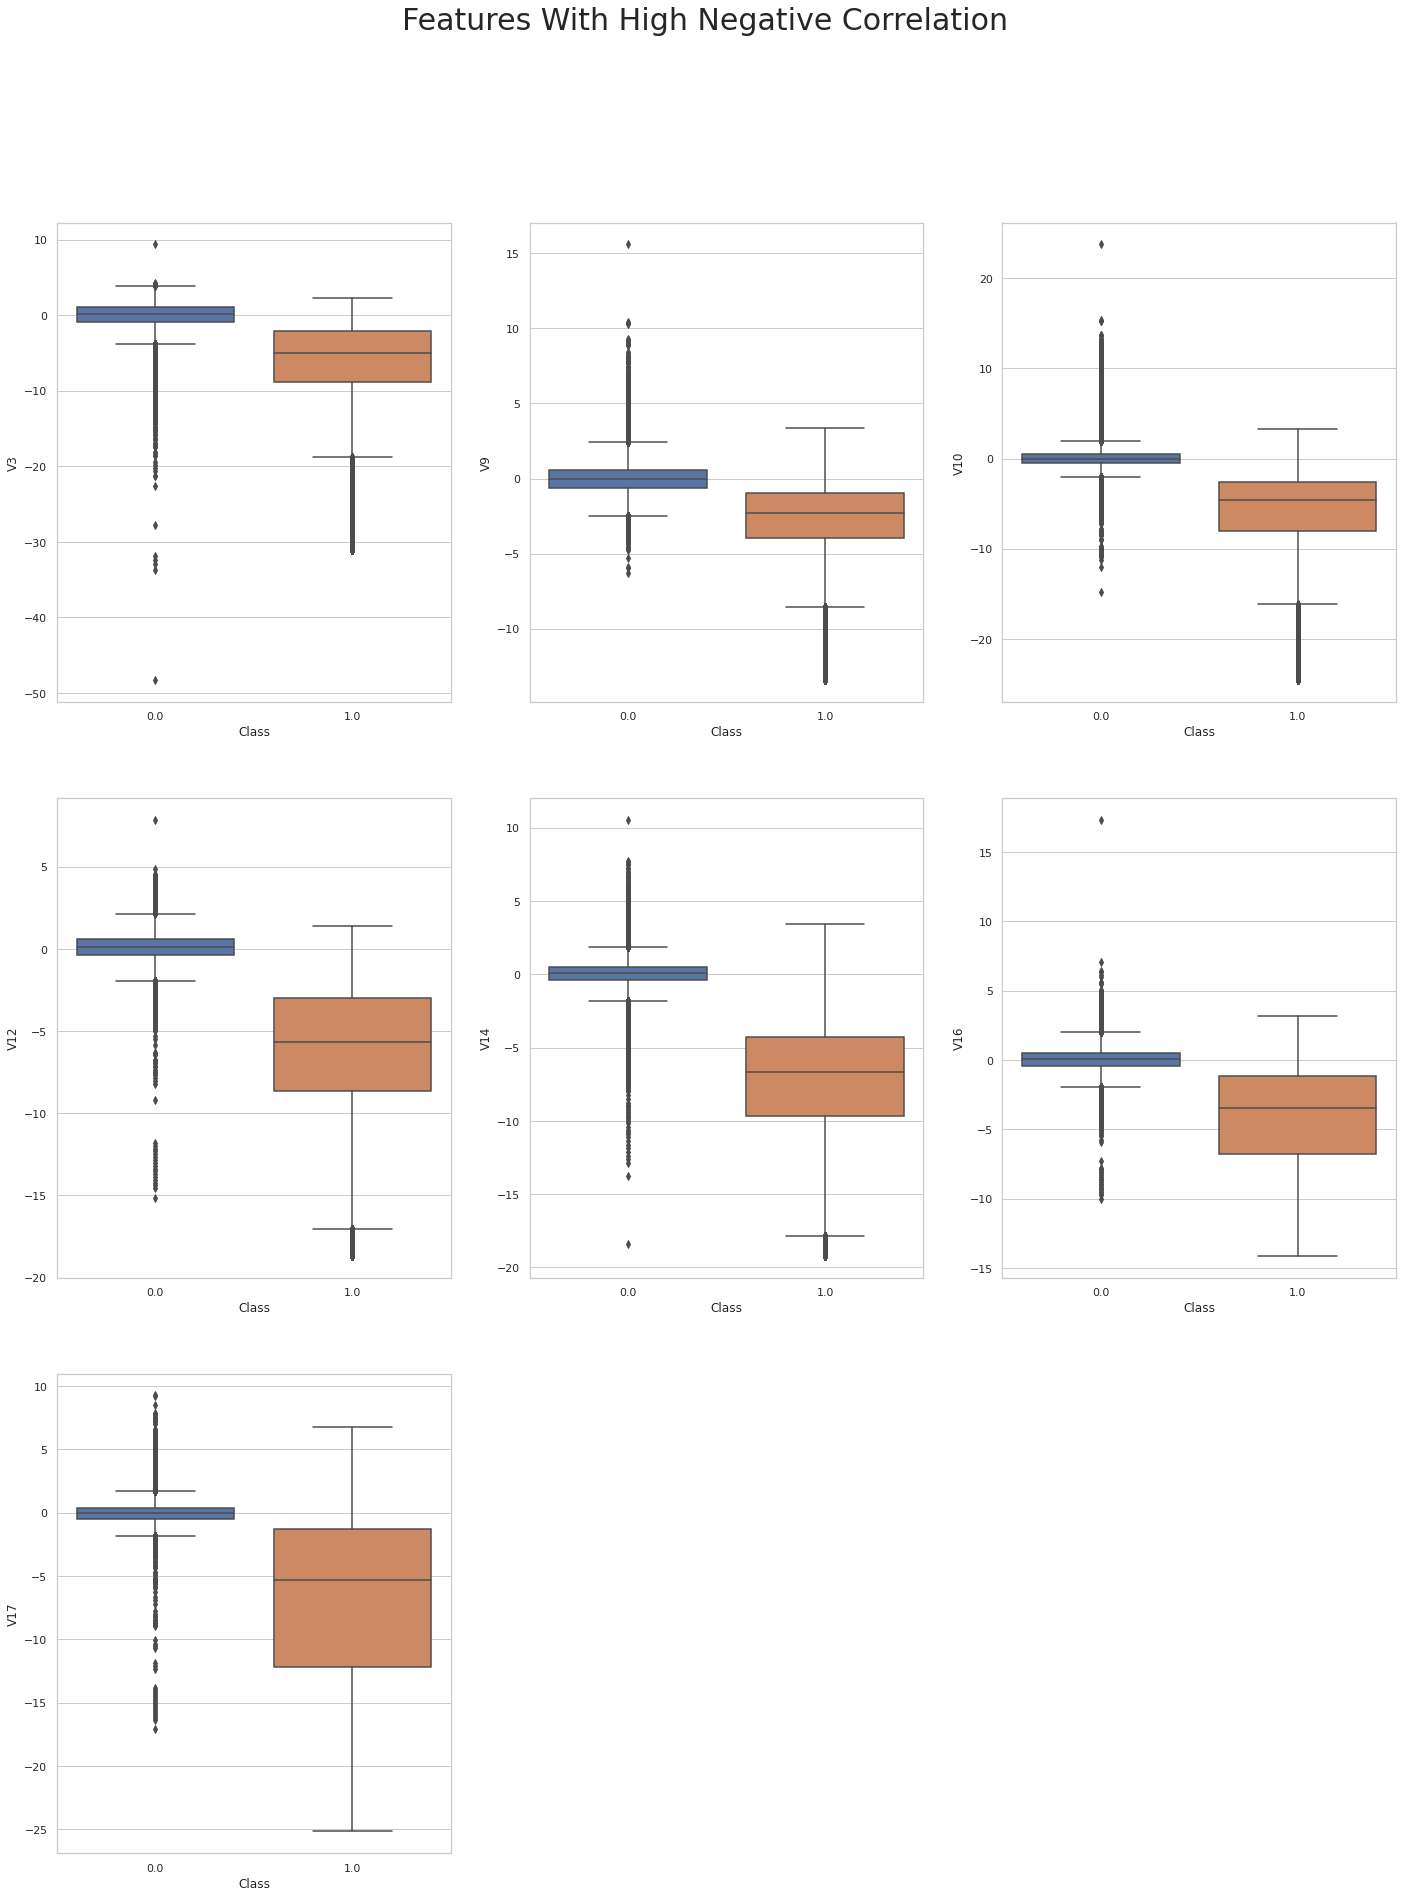

In [93]:
# box plot of the features with high negative correlation
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24, 30))
fig.suptitle('Features With High Negative Correlation', size=30)
sns.boxplot(x="Class", y="V3", data=train_res, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=train_res, ax=axes[0,1])
sns.boxplot(x="Class", y="V10", data=train_res, ax=axes[0,2])
sns.boxplot(x="Class", y="V12", data=train_res, ax=axes[1,0])
sns.boxplot(x="Class", y="V14", data=train_res, ax=axes[1,1])
sns.boxplot(x="Class", y="V16", data=train_res, ax=axes[1,2])
sns.boxplot(x="Class", y="V17", data=train_res, ax=axes[2,0])
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

In [94]:
# features with high positive correlations
corr[corr.Class > 0.5]

,Class
V2,0.506566
V4,0.711726
V11,0.697988
Class,1.000000


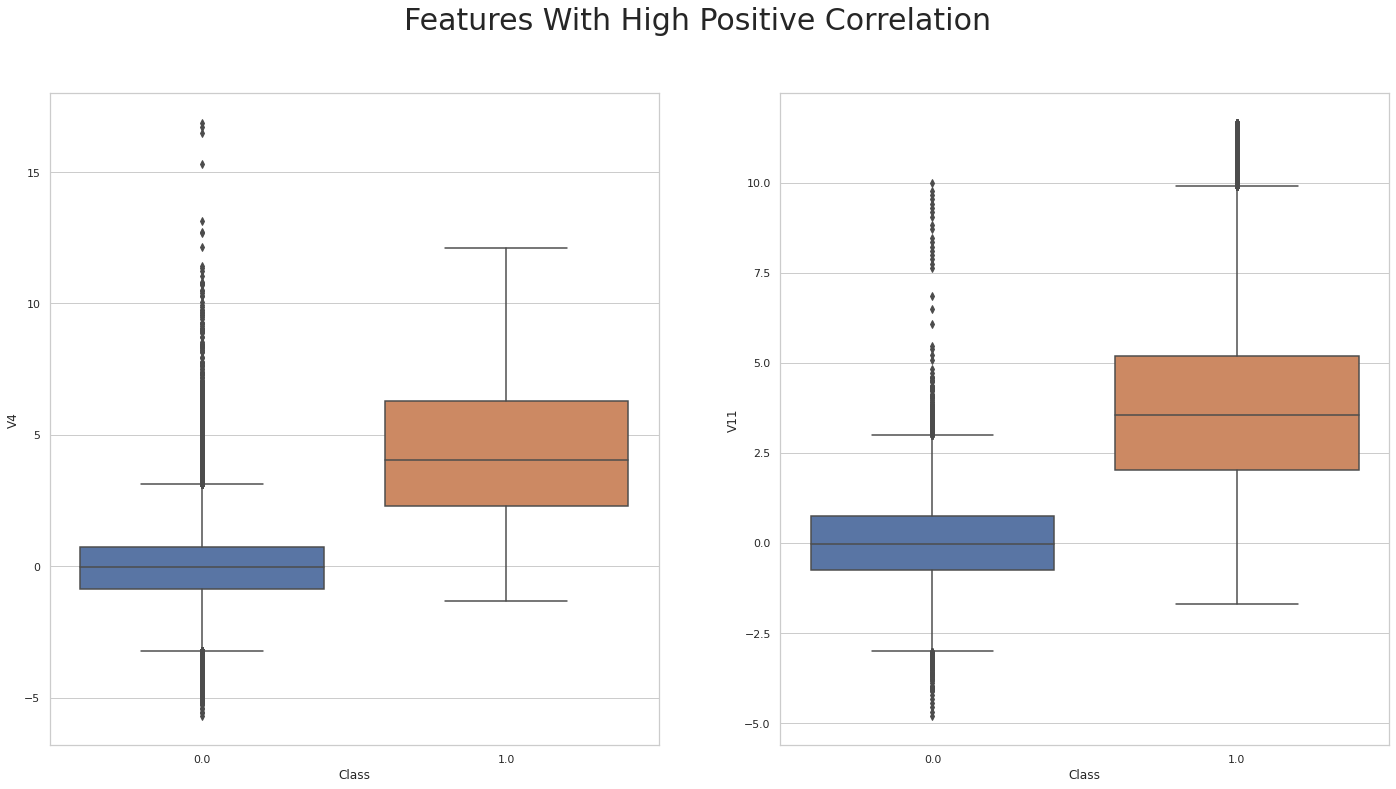

In [ ]:
# box plot of the features with high positive correlation
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
fig.suptitle('Features With High Positive Correlation', size=30)
sns.boxplot(x="Class", y="V4", data=train_res, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=train_res, ax=axes[1])

In [95]:
# removing extreme outliers
Q1 = train_res.quantile(0.25)
Q3 = train_res.quantile(0.75)
IQR = Q3 - Q1
train2 = train_res[~((train_res < (Q1-2.5*IQR)) | (train_res > (Q3+2.5*IQR))).any(axis=1)]

In [96]:
len_after = len(train2)
len_before = len(train_res)
len_diff = len(train_res) - len(train2)
print('We reduced our data size from {} observations by {} observations to {} observations.'.format(len_before, len_diff, len_after))

We reduced our data size from 454902 observations by 125546 observations to 329356 observations.


Text(0.5, 0, 'Class - 0:Non-Fraudulent; 1:Fraudulent')

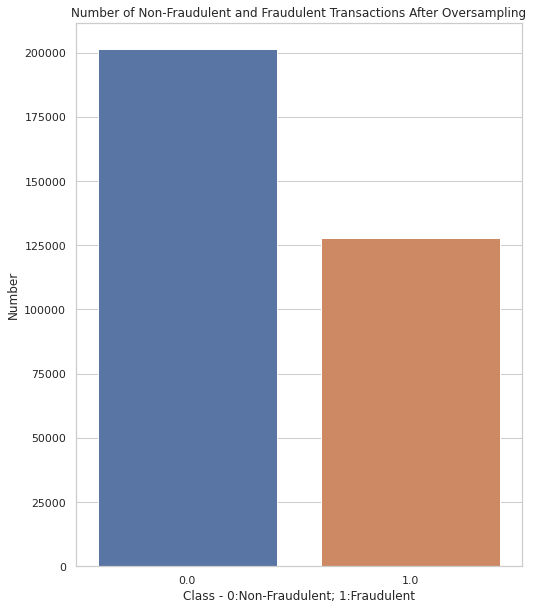

In [97]:
counts = train2['Class'].value_counts()
plt.figure(figsize=(8,10))
sns.barplot(x=counts.index, y=counts)
plt.title('Number of Non-Fraudulent and Fraudulent Transactions After Oversampling')
plt.ylabel('Number')
plt.xlabel('Class - 0:Non-Fraudulent; 1:Fraudulent')

**Visualising on 2D scatter plot using t-SNE**

In [ ]:
from sklearn.manifold import TSNE

subtrain2 = train2.sample(1000)
X = subtrain2.loc[:,:'V28']
y = subtrain2.loc[:,'Class']
X_tsne = TSNE(n_components=2, random_state=42, verbose=5).fit_transform(X.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.958153
[t-SNE] Computed conditional probabilities in 0.061s
[t-SNE] Iteration 50: error = 66.0208588, gradient norm = 0.2841528 (50 iterations in 0.429s)
[t-SNE] Iteration 100: error = 64.8233795, gradient norm = 0.2474175 (50 iterations in 0.440s)
[t-SNE] Iteration 150: error = 63.9843750, gradient norm = 0.2695001 (50 iterations in 0.441s)
[t-SNE] Iteration 200: error = 64.0377960, gradient norm = 0.2481779 (50 iterations in 0.401s)
[t-SNE] Iteration 250: error = 64.2120895, gradient norm = 0.2561422 (50 iterations in 0.422s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.212090
[t-SNE] Iteration 300: error = 0.9010705, gradient norm = 0.0013473 (50 iterations in 0.345s)
[t-SNE] Iteration 350: error = 0.7938609, gradient norm = 0.00037

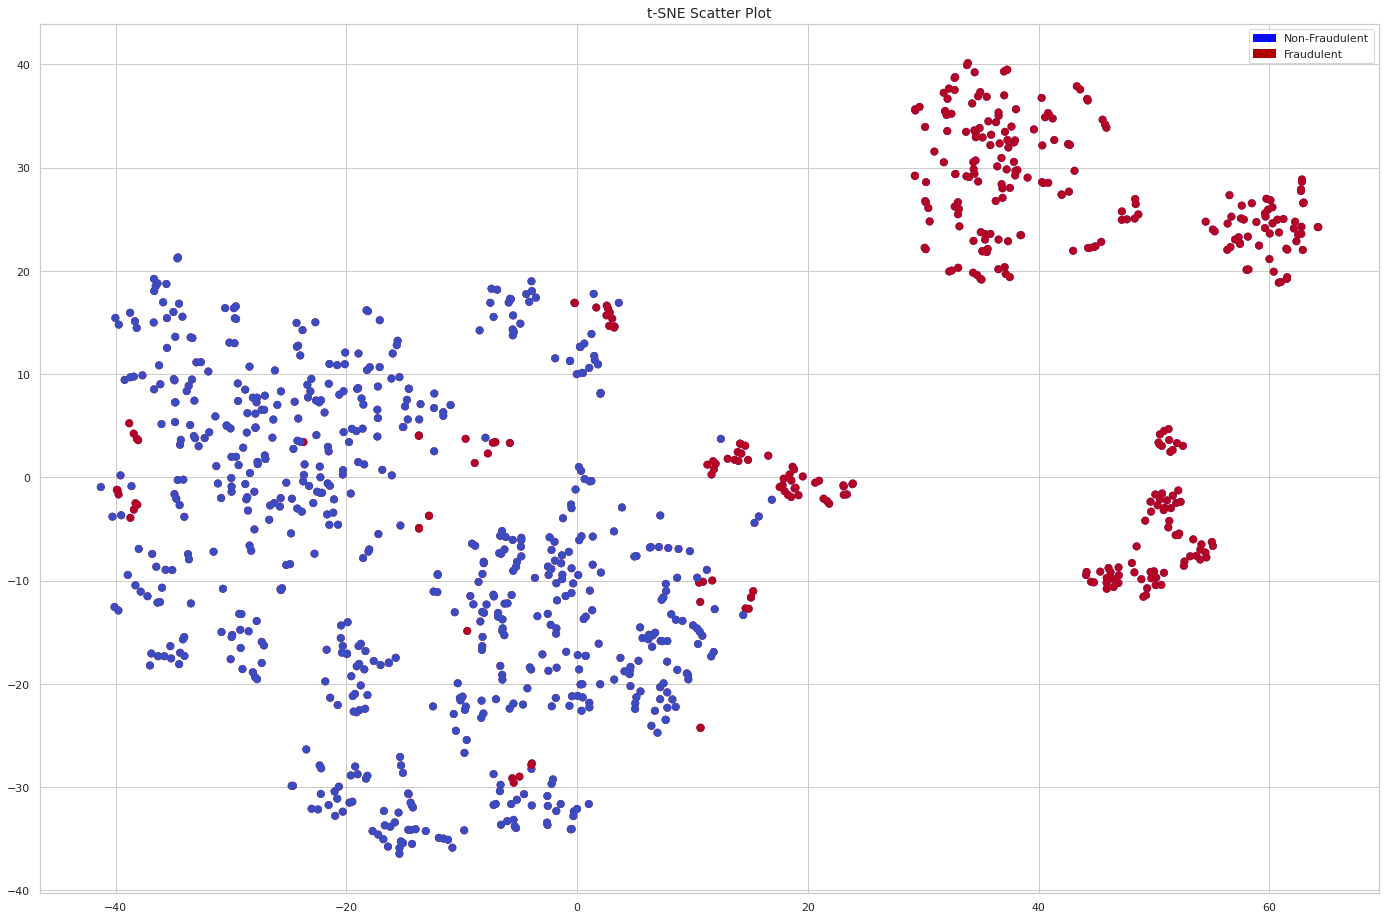

In [ ]:
# scatter plot
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(24,16))

blue_patch = mpatches.Patch(color='#0A0AFF', label='Non-Fraudulent')
red_patch = mpatches.Patch(color='#AF0000', label='Fraudulent')

ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraudulent', linewidths=2)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraudulent', linewidths=2)
ax.set_title('t-SNE Scatter Plot', fontsize=14)
ax.grid(True)
ax.legend(handles=[blue_patch, red_patch])

# ***Classification Algorithms***

In [98]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

In [99]:
subtrain2 = train2.sample(20000)
X_train = subtrain2.loc[:,:'V28'].values
y_train = subtrain2.loc[:,'Class'].values
X_test = test.loc[:,:'V28'].values
y_test = test.loc[:,'Class'].values

In [100]:
X_validation = X_test
y_validation = y_test

In [101]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (20000, 29) (56962, 29) 

Y_shapes:
 Y_train: Y_validation:
 (20000,) (56962,)


In [102]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [103]:
##Spot-Checking Algorithms

Log_Reg = LogisticRegression()
knears_neighbors = KNeighborsClassifier()
tree_clf = DecisionTreeClassifier()
SVC = SVC()
XGB_clf  = XGBClassifier()
RF_clf = RandomForestClassifier()

models = []

models.append(('LR', Log_Reg))
models.append(('KNN', knears_neighbors))
models.append(('CART', tree_clf))
models.append(('SVM', SVC))
models.append(('XGB', XGB_clf))
models.append(('RF', RF_clf))

#testing models

results = []
names = []

for name, model in models:
    model.fit(X_train, y_train)
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.988400 (0.001966)
KNN: 0.997613 (0.000609)
CART: 0.982870 (0.002672)
SVM: 0.995956 (0.000913)
XGB: 0.998568 (0.000527)
RF: 0.999864 (0.000147)


In [104]:
print ("Précision sur l'ensemble de formation: {: .3f}". format (RF_clf.score (X_train, y_train))) 
print ("Précision sur l'ensemble de validation: {: .3f}". format (RF_clf.score (X_validation, y_validation))) 

Précision sur l'ensemble de formation:  1.000
Précision sur l'ensemble de validation:  0.999


# ***Ecaluation Random forest***

In [121]:
#function for confusion matrix
def conf_matrix(predicted_values):
    Predictions_CM = confusion_matrix(y_test, predicted_values, labels = [0, 1])
    class_feat=creditcard_data['Class'].copy()
    class_feat= class_feat.unique()
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(Predictions_CM, annot=True, fmt='d', xticklabels=class_feat, yticklabels=class_feat)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

Recall_score: 0.8775510204081632
Precision_score: 0.5771812080536913
F-score: 0.6963562753036437


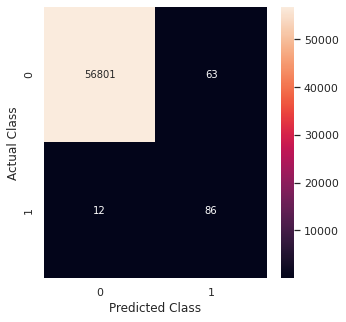

--------------------------------------------------
Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.58      0.88      0.70        98

    accuracy                           1.00     56962
   macro avg       0.79      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [122]:
#print('Accuracy MLP: '+ str(RF_clf.evaluate(X_test,y_test)[1]))
#print('Loss value: '+ str(RF_clf.evaluate(X_test,y_test)[0]))

Y_RF_pred = RF_clf.predict(X_test)
print('Recall_score: ' + str(recall_score(y_test,Y_RF_pred)))
print('Precision_score: ' + str(precision_score(y_test, Y_RF_pred)))
print('F-score: ' + str(f1_score(y_test,Y_RF_pred)))
conf_matrix(Y_RF_pred)

print('-'*50)

print('Random Forest Classifier:')
print(classification_report(y_test, Y_RF_pred))

# ***Evaluation XGBoost***

Recall_score: 0.8877551020408163
Precision_score: 0.13657770800627944
F-score: 0.236734693877551


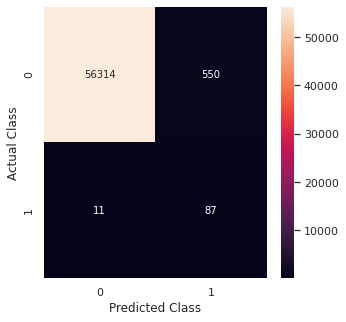

--------------------------------------------------
XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.89      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962



In [112]:
Y_XGB_pred = XGB_clf.predict(X_test)
print('Recall_score: ' + str(recall_score(y_test,Y_XGB_pred)))
print('Precision_score: ' + str(precision_score(y_test, Y_XGB_pred)))
print('F-score: ' + str(f1_score(y_test,Y_XGB_pred)))
conf_matrix(Y_XGB_pred)

print('-'*50)

print('XGBoost:')
print(classification_report(y_test, Y_XGB_pred))

# ***Evaluation SVM***

Recall_score: 0.550561797752809
Precision_score: 0.08536585365853659
F-score: 0.14781297134238314


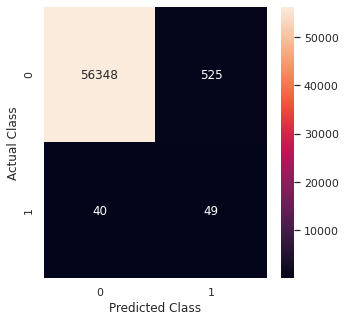

--------------------------------------------------
Support Vector Classifier:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56873
           1       0.09      0.54      0.15        89

    accuracy                           0.99     56962
   macro avg       0.54      0.77      0.57     56962
weighted avg       1.00      0.99      0.99     56962



In [ ]:
Y_SVM_pred = SVC.predict(X_test)
print('Recall_score: ' + str(recall_score(y_test,Y_SVM_pred)))
print('Precision_score: ' + str(precision_score(y_test, Y_SVM_pred)))
print('F-score: ' + str(f1_score(y_test,Y_SVM_pred)))
conf_matrix(Y_SVM_pred)

print('-'*50)

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

# ***Evaluation Tree Decession***

Recall_score: 0.797752808988764
Precision_score: 0.027832222657781264
F-score: 0.05378787878787879


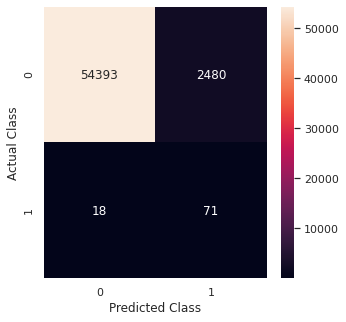

--------------------------------------------------
Tree Decession Classifier:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56873
           1       0.06      0.85      0.11        89

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [ ]:
Y_tree_pred = tree_clf.predict(X_test)
print('Recall_score: ' + str(recall_score(y_test,Y_tree_pred)))
print('Precision_score: ' + str(precision_score(y_test, Y_tree_pred)))
print('F-score: ' + str(f1_score(y_test,Y_tree_pred)))
conf_matrix(Y_tree_pred)

print('-'*50)

print('Tree Decession Classifier:')
print(classification_report(y_test, y_pred_tree))

# ***Evaluation KNN***

Recall_score: 0.8876404494382022
Precision_score: 0.05804555473916238
F-score: 0.10896551724137932


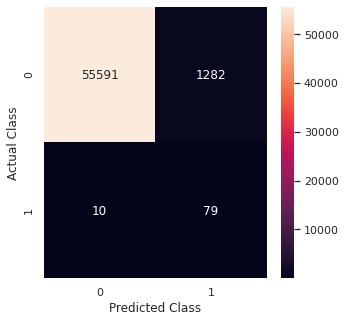

--------------------------------------------------
KNears Neighbors:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56873
           1       0.06      0.90      0.12        89

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



In [ ]:
Y_KNN_pred = knears_neighbors.predict(X_test)
print('Recall_score: ' + str(recall_score(y_test,Y_KNN_pred)))
print('Precision_score: ' + str(precision_score(y_test, Y_KNN_pred)))
print('F-score: ' + str(f1_score(y_test,Y_KNN_pred)))
conf_matrix(Y_KNN_pred)

print('-'*50)

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

# ***Evaluation Logistic Regression***

Recall_score: 0.8426966292134831
Precision_score: 0.031210986267166042
F-score: 0.06019261637239166


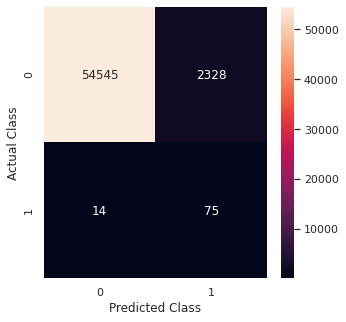

--------------------------------------------------
Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56873
           1       0.03      0.83      0.06        89

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.52     56962
weighted avg       1.00      0.96      0.98     56962



In [ ]:
Y_LR_pred = Log_Reg.predict(X_test)
print('Recall_score: ' + str(recall_score(y_test,Y_LR_pred)))
print('Precision_score: ' + str(precision_score(y_test, Y_LR_pred)))
print('F-score: ' + str(f1_score(y_test,Y_LR_pred)))
conf_matrix(Y_LR_pred)

print('-'*50)

print('Logistic Regression:')
print(classification_report(y_test, y_pred_Log_Reg))